# RAGdoll Key Modules Demo

Hands-on walkthrough for ingestion, chunking, embeddings, storage layers, and orchestration. Every example relies on the sample assets under `tests/test_data`, so the notebook can run offline.

> **Note:** 
- Set `USE_OPENAI = True` at the top to use real OpenAI embeddings, `False` for fake embeddings.
- Sections 5 and 6 use LLM endpoints for entity extraction via `get_llm_caller`. Export `OPENAI_API_KEY` (or add it to `.env`) before running them.
- Section 7.2 demonstrates direct LLM calls for text summarization (optional).

## What you'll see

1. **Ingestion** – Load documents with `DocumentLoaderService`
2. **Chunking** – Split text with `ragdoll.chunkers`
3. **Embeddings** – Generate vectors with OpenAI or fake embeddings
4. **Vector stores** – Store and query embeddings with Chroma
5. **Entity extraction** – Extract entities using `EntityExtractionService` (two approaches)
6. **Full pipeline** – Orchestrate the complete workflow with `ingest_documents()`
7. **Graph persistence** – Save and load knowledge graphs
8. **Manual pipeline** – Advanced pipeline control for customization
9. **Retrieval strategies** – Vector, graph, and hybrid retrieval with parallel processing
10. **Advanced patterns** – Weighted hybrid, graph expansion, and async retrieval

Each section builds progressively, teaching components before complete systems.

In [1]:
from pathlib import Path
from pprint import pprint
import shutil
import time

from langchain_core.documents import Document

from ragdoll import Ragdoll
from ragdoll.app_config import bootstrap_app
from ragdoll.ingestion import DocumentLoaderService
from ragdoll.chunkers import get_text_splitter, split_documents
from ragdoll.embeddings import get_embedding_model
from ragdoll.vector_stores import vector_store_from_config
from ragdoll.config.base_config import VectorStoreConfig
from ragdoll.graph_stores import get_graph_store
from ragdoll.entity_extraction import EntityExtractionService
from ragdoll.entity_extraction.models import Graph, GraphNode, GraphEdge
from ragdoll.entity_extraction.graph_persistence import GraphPersistenceService
from ragdoll.retrieval import VectorRetriever, GraphRetriever, HybridRetriever
from ragdoll.llms import get_llm_caller
from ragdoll.llms.callers import call_llm_sync
from ragdoll.pipeline import ingest_documents, IngestionPipeline, IngestionOptions
from dotenv import load_dotenv

In [2]:
load_dotenv(override=True)

DATA_DIR = Path('../tests/test_data').resolve()
STATE_DIR = Path('demo_state').resolve()
STATE_DIR.mkdir(exist_ok=True)

SAMPLE_TXT = DATA_DIR / 'test_txt.txt'
#SAMPLE_TXT = DATA_DIR / '*'

# Set to True to use real OpenAI embeddings, False for fake embeddings
USE_OPENAI = True

app_config = bootstrap_app(
    overrides={
        'monitor': {'enabled': False, 'collect_metrics': False},
    }
)


def normalize_documents(raw_docs):
    docs = []
    for entry in raw_docs:
        if isinstance(entry, Document):
            docs.append(entry)
        elif isinstance(entry, dict):
            docs.append(
                Document(
                    page_content=str(entry.get('page_content', '')),
                    metadata=entry.get('metadata', {}) or {},
                )
            )
        else:
            docs.append(Document(page_content=str(entry), metadata={}))
    return docs


def reset_subdir(name: str) -> Path:
    path = STATE_DIR / name
    if path.exists():
        for attempt in range(5):
            try:
                shutil.rmtree(path)
                break
            except PermissionError:
                time.sleep(0.5)
        else:
            timestamped = STATE_DIR / f"{name}_{int(time.time())}"
            timestamped.mkdir(parents=True, exist_ok=True)
            print(f"Warning: {path} was locked, using {timestamped} instead.")
            return timestamped
    path.mkdir(parents=True, exist_ok=True)
    return path

In [3]:
import os
k = os.getenv("OPENAI_API_KEY")
print("Key len:", len(k), "prefix:", k[:12], "suffix:", k[-6:])

Key len: 164 prefix: sk-proj-Ml-_ suffix: NUDc8A


## 1. Load sample data
`DocumentLoaderService` fans out across the loader registry defined in `ragdoll/config/default_config.yaml`. We point it at the lightweight TXT fixture so the demo does not need optional dependencies.


In [4]:
loader = DocumentLoaderService(
    app_config=app_config,
    use_cache=False,
    collect_metrics=False,
)

raw_documents = loader.ingest_documents([str(SAMPLE_TXT)])
documents = normalize_documents(raw_documents)

print(f"Loaded {len(documents)} document(s) from {SAMPLE_TXT.name}")
print('Metadata sample:')
pprint(documents[0].metadata)
print('Preview:')
print(documents[0].page_content[:400])


Loaded 1 document(s) from test_txt.txt
Metadata sample:
{'source': 'C:\\dev\\RAGdoll\\tests\\test_data\\test_txt.txt'}
Preview:
Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved information into a dynamic knowledge graph rather than treating it as flat text chunks. At its core, it begins with a user query that triggers a retrieval step from a vector database or search index. Instead of directly feeding retrieved documents into a


## 2. Chunk documents
`ragdoll.chunkers.get_text_splitter` mirrors the strategies in [`docs/chunking.md`](../docs/chunking.md). Reusing the splitter instance keeps experiments consistent when you tweak chunk sizes/overlap.


In [5]:
splitter = get_text_splitter(
    splitter_type='recursive',
    chunk_size=250,
    chunk_overlap=40,
    app_config=app_config,
)
chunks = split_documents(documents, text_splitter=splitter)

print(f"Created {len(chunks)} chunk(s)")
for idx, chunk in enumerate(chunks[:3], start=1):
    preview = chunk.page_content[:180].replace('\n', ' ')
    print(f"Chunk {idx} metadata: {chunk.metadata}")
    print(preview)
    print('---')


Created 20 chunk(s)
Chunk 1 metadata: {'source': 'C:\\dev\\RAGdoll\\tests\\test_data\\test_txt.txt', 'chunk_id': '7623481e_0_v1'}
Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved information into a dynamic knowled
---
Chunk 2 metadata: {'source': 'C:\\dev\\RAGdoll\\tests\\test_data\\test_txt.txt', 'chunk_id': '7623481e_1_v1'}
it as flat text chunks. At its core, it begins with a user query that triggers a retrieval step from a vector database or search index. Instead of directly feeding retrieved docume
---
Chunk 3 metadata: {'source': 'C:\\dev\\RAGdoll\\tests\\test_data\\test_txt.txt', 'chunk_id': '7623481e_2_v1'}
the system parses these documents to extract entities (such as people, organizations, or concepts) and relationships (like "works at" or "caused by") using named entity recognition
---


## 3. Create embeddings
`ragdoll.embeddings.get_embedding_model` instantiates providers dynamically. Passing `provider="fake"` gives deterministic vectors without hitting OpenAI/HuggingFace, but the rest of the flow matches production usage.


In [6]:
# Uncomment to verify OPENAI_API_KEY is loaded
#print(os.getenv("OPENAI_API_KEY"))

In [7]:
embedding_inputs = [chunk.page_content for chunk in chunks[:3]]
if not embedding_inputs:
    embedding_inputs = [documents[0].page_content]

embeddings = (
    get_embedding_model() if USE_OPENAI 
    else get_embedding_model(provider='fake', size=256)
)
vectors = embeddings.embed_documents(embedding_inputs)

print(f"Generated {len(vectors)} embedding vector(s) with dimension {len(vectors[0])}")
print('First vector slice:', vectors[0][:8])

Generated 3 embedding vector(s) with dimension 1536
First vector slice: [-0.0022252982016652822, 0.010352334007620811, -0.011473081074655056, 0.009996026754379272, -0.004295117221772671, -0.017763515934348106, -0.015794111415743828, -0.014433667063713074]


## 4. Build a vector store
`vector_store_from_config` consumes a `VectorStoreConfig`, so you can swap FAISS/Chroma/etc. on demand. This cell provisions a Chroma collection under `demo_state` and runs a quick similarity query.


In [8]:
core_store_dir = reset_subdir('chroma_core_demo')
vector_config = VectorStoreConfig(
    enabled=True,
    store_type='chroma',
    params={
        'collection_name': 'ragdoll_core_demo',
        'persist_directory': str(core_store_dir),
    },
)

demo_vector_store = vector_store_from_config(
    vector_config,
    embedding=embeddings,
)

demo_vector_store.add_documents(chunks)
question = 'What content lives in the txt sample?'
results = demo_vector_store.similarity_search(question, k=2)
for idx, doc in enumerate(results, start=1):
    snippet = doc.page_content[:160].replace('\n', ' ')
    print(f"Result {idx} (source={doc.metadata.get('source')}) -> {snippet}")


Result 1 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt) -> it as flat text chunks. At its core, it begins with a user query that triggers a retrieval step from a vector database or search index. Instead of directly feed
Result 2 (source=C:\dev\RAGdoll\tests\test_data\test_txt.txt) -> Finally, the output includes not just the generated text but optional graph visualizations or citations mapping back to original documents. This traceability im


## 5. Entity Extraction Service

The `EntityExtractionService` extracts entities and relationships from text to build knowledge graphs. It can work with raw chunks or existing vector stores.

**Two approaches:**
- **5a. Direct extraction from chunks** - Extract entities from text chunks directly
- **5b. Extraction from vector store** - Extract from an already-populated vector store (guarantees vector_id alignment)

In [9]:
### 5a. Extract entities from chunks directly

import os
from ragdoll.entity_extraction import EntityExtractionService

# Initialize LLM for entity extraction
class ExampleFallbackLLM:
    async def call(self, prompt: str) -> str:
        return "Fallback response (no API key for entity extraction)"

if not os.getenv('OPENAI_API_KEY'):
    print("OPENAI_API_KEY not set, using fallback LLM for demo.")
    llm_caller = ExampleFallbackLLM()
else:
    llm_caller = get_llm_caller(app_config=app_config)
    if llm_caller is None:
        print("Unable to initialize LLM, using fallback.")
        llm_caller = ExampleFallbackLLM()
    else:
        print("LLM initialized for entity extraction.")

# Create entity extraction service with config
entity_extractor = EntityExtractionService(
    config={
        "entity_types": ["Person", "Organization", "Location", "Technology"],
        "use_llm": True,  # Use LLM for better extraction quality
    },
    llm_caller=llm_caller,
    app_config=app_config
)

# Extract entities from our chunks
print(f"\nExtracting entities from {len(chunks)} chunks...")
extracted_graph = await entity_extractor.extract(chunks)

print(f"\n✅ Extraction complete!")
print(f"   Entities found: {len(extracted_graph.nodes)}")
print(f"   Relationships found: {len(extracted_graph.edges)}")

# Show sample entities
if extracted_graph.nodes:
    print("\n📌 Sample entities:")
    for node in list(extracted_graph.nodes)[:5]:
        props = getattr(node, 'properties', {})
        entity_name = props.get('name') or props.get('text', node.id)
        print(f"   - [{node.type}] {entity_name}")

LLM initialized for entity extraction.

Extracting entities from 20 chunks...

Extracting entities from 20 chunks...

✅ Extraction complete!
   Entities found: 82
   Relationships found: 49

📌 Sample entities:
   - [ORG] Retrieval-Augmented Generation
   - [ORG] RAG
   - [ENTITY] RAG_GRAPH
   - [ENTITY] TRADITIONAL_RAG_SYSTEMS
   - [ENTITY] RETRIEVED_INFORMATION

✅ Extraction complete!
   Entities found: 82
   Relationships found: 49

📌 Sample entities:
   - [ORG] Retrieval-Augmented Generation
   - [ORG] RAG
   - [ENTITY] RAG_GRAPH
   - [ENTITY] TRADITIONAL_RAG_SYSTEMS
   - [ENTITY] RETRIEVED_INFORMATION


In [10]:
### 5b. Extract entities from existing vector store

# Extract from the demo_vector_store created in Section 4
# This approach guarantees graph nodes have vector_ids matching the vector store

print("=== Extracting Entities from Existing Vector Store ===\n")

if 'demo_vector_store' in globals():
    # Extract using the same entity extractor
    vs_extracted_graph = await entity_extractor.extract_from_vector_store(demo_vector_store)
    
    print(f"✅ Extraction from vector store complete!")
    print(f"   Entities found: {len(vs_extracted_graph.nodes)}")
    print(f"   Relationships found: {len(vs_extracted_graph.edges)}")
    
    # Verify nodes have vector_id references
    if vs_extracted_graph.nodes:
        nodes_with_vector_id = sum(1 for node in vs_extracted_graph.nodes 
                                   if 'vector_id' in getattr(node, 'properties', {}))
        print(f"   Nodes with vector_id: {nodes_with_vector_id}/{len(vs_extracted_graph.nodes)} ✅")
        
        # Show sample nodes with their vector_ids
        print("\n📌 Sample nodes with vector_id references:")
        for node in list(vs_extracted_graph.nodes)[:3]:
            props = getattr(node, 'properties', {})
            vector_id = props.get('vector_id', 'N/A')
            entity_name = props.get('name') or props.get('text', node.id)
            print(f"   - [{node.type}] {entity_name}")
            if vector_id != 'N/A':
                print(f"     vector_id: {vector_id[:36]}...")
else:
    print("⚠️  Run Section 4 first to create demo_vector_store")

=== Extracting Entities from Existing Vector Store ===

✅ Extraction from vector store complete!
   Entities found: 75
   Relationships found: 45
   Nodes with vector_id: 75/75 ✅

📌 Sample nodes with vector_id references:
   - [ORG] Retrieval-Augmented Generation
     vector_id: d32bd56d-cf1a-4981-b186-bf775847540c...
   - [ORG] RAG
     vector_id: d32bd56d-cf1a-4981-b186-bf775847540c...
   - [ENTITY] RAG_GRAPH
     vector_id: d32bd56d-cf1a-4981-b186-bf775847540c...
✅ Extraction from vector store complete!
   Entities found: 75
   Relationships found: 45
   Nodes with vector_id: 75/75 ✅

📌 Sample nodes with vector_id references:
   - [ORG] Retrieval-Augmented Generation
     vector_id: d32bd56d-cf1a-4981-b186-bf775847540c...
   - [ORG] RAG
     vector_id: d32bd56d-cf1a-4981-b186-bf775847540c...
   - [ENTITY] RAG_GRAPH
     vector_id: d32bd56d-cf1a-4981-b186-bf775847540c...


## 6. Full Ingestion Pipeline

Now that we've seen how to use the `EntityExtractionService` directly, let's see how the `IngestionPipeline` orchestrates the entire workflow: loading → chunking → embedding → entity extraction → storage.

The `ingest_documents()` helper function provides a clean API for end-to-end processing.

✅ Full pipeline complete!
Documents processed: 1
Chunks created: 5
Entities extracted: 81
Relationships extracted: 43
Vector entries added: 5
Graph entries added: 43

Visualizing graph with 81 nodes and 43 edges...

Graph visualization saved as 'C:\dev\RAGdoll\examples\demo_state\graph_demo\graph_demo.png'
Graph data saved as 'C:\dev\RAGdoll\examples\demo_state\graph_demo\graph_output.json'

Graph visualization saved as 'C:\dev\RAGdoll\examples\demo_state\graph_demo\graph_demo.png'
Graph data saved as 'C:\dev\RAGdoll\examples\demo_state\graph_demo\graph_output.json'


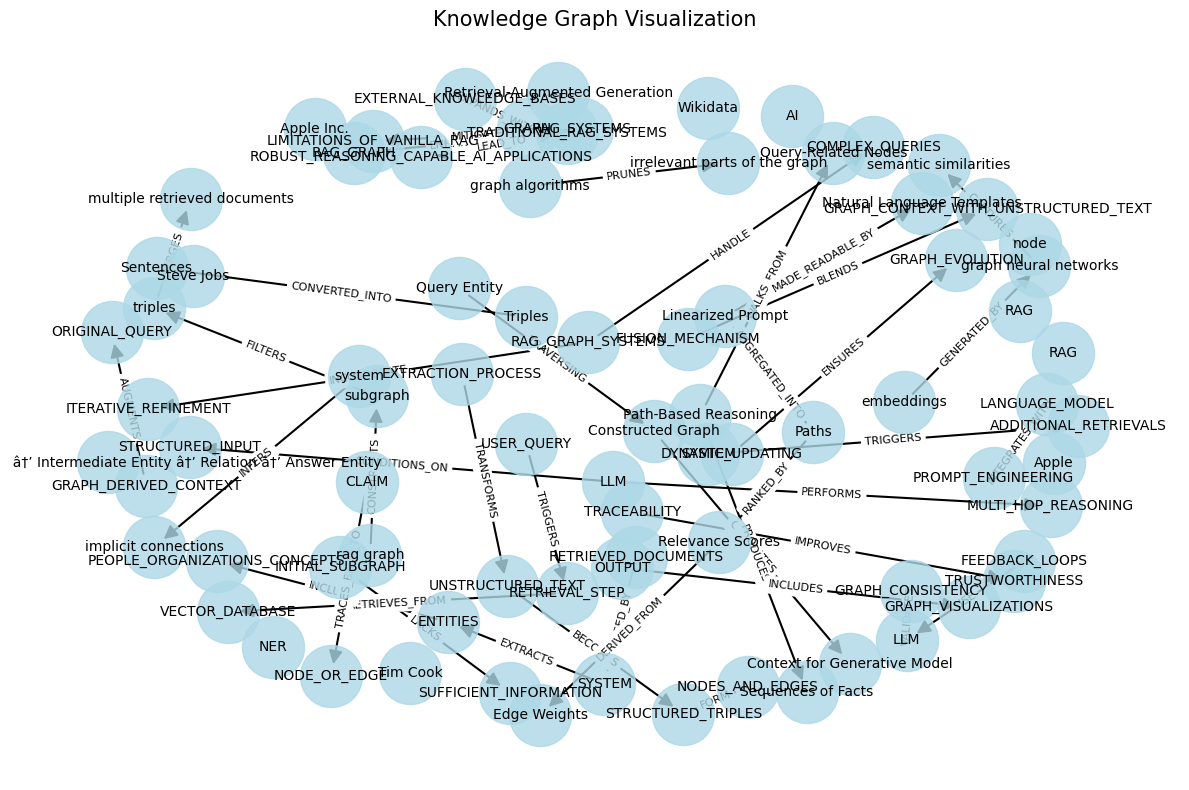

In [11]:
### 6a. Full pipeline with entity extraction

# Create directories
graph_store_dir = reset_subdir('graph_demo')
graph_image_path = graph_store_dir / 'graph_demo.png'
graph_store_file = graph_store_dir / 'graph.pkl'

# Configure ingestion options - complete workflow
options = IngestionOptions(
    batch_size=5,
    extract_entities=True,
    chunking_options={'chunk_size': 1000, 'chunk_overlap': 200},
    vector_store_options={
        "store_type": "chroma",
        "params": {
            "collection_name": "graph_demo",
            "persist_directory": str(graph_store_dir / "vector"),
        },
    },
    graph_store_options={
        "store_type": "networkx",
        "output_file": str(graph_store_file),
    },
    llm_caller=llm_caller,
    entity_extraction_options={
        "entity_types": ["Person", "Organization", "Location"],
        "use_llm": True,
    },
)

# Run complete ingestion pipeline
sources = [str(SAMPLE_TXT)]
result = await ingest_documents(sources, options=options)

# Extract results
stats = result.get("stats", {})
graph = result.get("graph")
graph_store = result.get("graph_store")
graph_retriever = result.get("graph_retriever")
pipeline_vector_store = result.get("vector_store")

# Print results
print(f"✅ Full pipeline complete!")
print(f"Documents processed: {stats.get('documents_processed')}")
print(f"Chunks created: {stats.get('chunks_created')}")
print(f"Entities extracted: {stats.get('entities_extracted')}")
print(f"Relationships extracted: {stats.get('relationships_extracted')}")
print(f"Vector entries added: {stats.get('vector_entries_added')}")
print(f"Graph entries added: {stats.get('graph_entries_added')}")

if stats.get("errors"):
    print(f"⚠️ Warnings/Errors:")
    for error in stats["errors"]:
        print(f"  - {error}")

# Visualize the graph
if graph and hasattr(graph, 'nodes') and graph.nodes:
    print(f"\nVisualizing graph with {len(graph.nodes)} nodes and {len(graph.edges)} edges...")
    from ragdoll.utils import visualize_graph
    visualize_graph(graph, output_image_path=str(graph_image_path), 
                   output_json_path=str(graph_store_dir / "graph_output.json"))
else:
    print('No graph available to visualize.')

### 6b. Pipeline comparison: with vs without entities

For comparison, let's run the pipeline without entity extraction to see the difference.

In [12]:
# Run pipeline WITHOUT entity extraction (vector-only mode)
vector_only_dir = reset_subdir('vector_only_demo')

vector_only_options = IngestionOptions(
    batch_size=5,
    extract_entities=False,  # Skip entity extraction
    skip_graph_store=True,   # No graph storage needed
    chunking_options={'chunk_size': 1000, 'chunk_overlap': 200},
    vector_store_options={
        "store_type": "chroma",
        "params": {
            "collection_name": "vector_only_demo",
            "persist_directory": str(vector_only_dir / "vector"),
        },
    },
)

vector_only_result = await ingest_documents(sources, options=vector_only_options)
vector_only_stats = vector_only_result.get("stats", {})

print(f"✅ Vector-only pipeline complete!")
print(f"Documents processed: {vector_only_stats.get('documents_processed')}")
print(f"Chunks created: {vector_only_stats.get('chunks_created')}")
print(f"Vector entries added: {vector_only_stats.get('vector_entries_added')}")
print(f"Entities extracted: {vector_only_stats.get('entities_extracted', 0)}")
print(f"\n📊 Comparison:")
print(f"   With entities: {stats.get('entities_extracted', 0)} entities, {stats.get('relationships_extracted', 0)} relationships")
print(f"   Without entities: Pure vector search only")

✅ Vector-only pipeline complete!
Documents processed: 1
Chunks created: 5
Vector entries added: 5
Entities extracted: 0

📊 Comparison:
   With entities: 81 entities, 43 relationships
   Without entities: Pure vector search only


## 7. Graph Store Persistence and Loading

After entity extraction, the graph is automatically persisted. Let's verify the persistence and demonstrate loading.

### 7.1. Save and Load Graph

In [13]:
# Save and load graph demonstration
if 'graph_store' in globals() and graph_store is not None and 'graph' in globals():
    print("=== Saving Graph ===")
    
    # The graph is already persisted to disk via the pickle file from Section 5
    # But we can also save it programmatically using the Graph object
    save_path = graph_store_dir / "saved_graph.pkl"
    
    # Save using NetworkX pickle
    import pickle
    with open(save_path, 'wb') as f:
        pickle.dump(graph_store.store, f)
    
    print(f"✅ Graph saved to: {save_path}")
    print(f"   Nodes: {graph_store.store.number_of_nodes()}")
    print(f"   Edges: {graph_store.store.number_of_edges()}\n")
    
    # Load the graph back from file
    print("=== Loading Graph ===")
    from ragdoll.graph_stores import GraphStoreWrapper
    import networkx as nx
    
    # Load NetworkX graph from pickle
    with open(save_path, 'rb') as f:
        loaded_nx_graph = pickle.load(f)
    
    # Wrap in GraphStoreWrapper
    loaded_graph_store = GraphStoreWrapper(
        store_type="networkx",
        store_impl=loaded_nx_graph,
        config={}
    )
    
    print(f"✅ Graph loaded from: {save_path}")
    print(f"   Nodes: {loaded_graph_store.store.number_of_nodes()}")
    print(f"   Edges: {loaded_graph_store.store.number_of_edges()}\n")
    
    # Verify the loaded graph works with retrieval
    print("=== Testing Loaded Graph with Retrieval ===")
    
    test_retriever = GraphRetriever(
        graph_store=loaded_graph_store,
        vector_store=demo_vector_store,
        embedding_model=embeddings,
        top_k=3,
        max_hops=1
    )
    
    test_query = "What entities are in the document?"
    test_results = test_retriever.get_relevant_documents(test_query)
    
    print(f"Retrieved {len(test_results)} nodes from loaded graph")
    for idx, doc in enumerate(test_results[:3], start=1):
        node_type = doc.metadata.get('node_type', 'unknown')
        node_id = doc.metadata.get('node_id', 'unknown')
        print(f"{idx}. [{node_type}] {node_id}")
    
    print("\n✅ Save/load cycle successful!")
else:
    print("Graph or graph_store not available. Run Section 5 first.")

=== Saving Graph ===
✅ Graph saved to: C:\dev\RAGdoll\examples\demo_state\graph_demo\saved_graph.pkl
   Nodes: 81
   Edges: 43

=== Loading Graph ===
✅ Graph loaded from: C:\dev\RAGdoll\examples\demo_state\graph_demo\saved_graph.pkl
   Nodes: 81
   Edges: 43

=== Testing Loaded Graph with Retrieval ===


Chroma get() returned no embeddings data. Results: True, has 'embeddings' key: True
Failed to retrieve any embeddings from vector store (requested 5 unique IDs)
No embeddings available for nodes, falling back to fuzzy matching
Failed to retrieve any embeddings from vector store (requested 5 unique IDs)
No embeddings available for nodes, falling back to fuzzy matching


Retrieved 5 nodes from loaded graph
1. [ENTITY] llm-f7f365ae53fc4c448c1f27c3df6104ba
2. [ENTITY] llm-04c7ca19448942c9b1fe4d04f95a8891
3. [ENTITY] llm-81d1de28dca0478fa5b809c9a8afef21

✅ Save/load cycle successful!


### 7.2. Test with LLM (Optional)

In [14]:
import os

if not os.getenv('OPENAI_API_KEY'):
    raise EnvironmentError('Set OPENAI_API_KEY before calling the real OpenAI demo cell.')

openai_llm_caller = get_llm_caller(app_config=app_config)

sample_text = chunks[0].page_content if chunks else documents[0].page_content
prompt = (
    'Summarize the following text sample in one sentence. Mention what the document is about and highlight any key people, organizations, or actions.'
    f"{sample_text[:2048]}"
)
print('Sample excerpt:', sample_text[:360].replace('\n', ' '))
llm_reply = call_llm_sync(openai_llm_caller, prompt)
print('OpenAI response:', llm_reply)


Sample excerpt: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved information into a dynamic knowledge graph rather than treating it as flat text chunks. At its core, it
OpenAI response: The document discusses Rag graph, an advanced Retrieval-Augmented Generation system that organizes retrieved information into a dynamic knowledge graph, improving upon traditional methods that use flat text chunks.
OpenAI response: The document discusses Rag graph, an advanced Retrieval-Augmented Generation system that organizes retrieved information into a dynamic knowledge graph, improving upon traditional methods that use flat text chunks.


## 8. Manual Pipeline (Advanced)

For advanced users who want more control, you can manually instantiate the `IngestionPipeline` instead of using the `ingest_documents()` helper.

In [15]:
pipeline_store_dir = reset_subdir('chroma_pipeline_demo')
pipeline_vector_config = VectorStoreConfig(
    enabled=True,
    store_type='chroma',
    params={
        'collection_name': 'ragdoll_pipeline_demo',
        'persist_directory': str(pipeline_store_dir),
    },
)
pipeline_vector_store = vector_store_from_config(
    pipeline_vector_config,
    embedding=embeddings,
)

pipeline = IngestionPipeline(
    app_config=app_config,
    content_extraction_service=DocumentLoaderService(
        app_config=app_config,
        use_cache=False,
        collect_metrics=False,
    ),
    embedding_model=embeddings,
    vector_store=pipeline_vector_store,
    options=IngestionOptions(
        batch_size=2,
        extract_entities=False,
        skip_graph_store=True,
        chunking_options={'chunk_size': 300, 'chunk_overlap': 60, 'splitter_type': 'recursive'},
    ),
)

pipeline_stats = await pipeline.ingest([str(SAMPLE_TXT)])
pipeline_stats


{'documents_processed': 1,
 'chunks_created': 17,
 'entities_extracted': 0,
 'relationships_extracted': 0,
 'vector_entries_added': 17,
 'graph_entries_added': 0,
 'errors': [],
 'graph_retriever_available': False}

## 9. Retrieval Strategies

The refactored `ragdoll.retrieval` module provides clean separation between vector, graph, and hybrid retrieval strategies.

### 9.1. Parallel Processing for Large-Scale Ingestion

RAGdoll's `IngestionPipeline` supports parallel processing to speed up embedding generation and storage operations.

In [16]:
import time
from ragdoll.vector_stores import vector_store_from_config

# Create test documents for parallel processing demo
embedding_test_chunks = [
    Document(
        page_content=f"Test document {i+1} about machine learning, AI, and technology.",
        metadata={"source": f"test_{i+1}.txt", "chunk_id": i+1}
    )
    for i in range(50)  # More chunks for better benchmark
]

print(f"Created {len(embedding_test_chunks)} test chunks for embedding benchmark")

Created 50 test chunks for embedding benchmark


In [17]:
# Benchmark: Sequential vs Parallel Embedding Generation
print("=== Sequential Embedding Benchmark ===\n")

embedding_dir_seq = reset_subdir('embed_sequential')
embed_store_seq = vector_store_from_config(
    VectorStoreConfig(
        enabled=True,
        store_type='chroma',
        params={
            'collection_name': 'embed_seq',
            'persist_directory': str(embedding_dir_seq),
        },
    ),
    embedding=embeddings,
)

# Sequential: max_concurrent = 1
start = time.time()
seq_ids = await embed_store_seq.add_documents_parallel(
    embedding_test_chunks,
    batch_size=10,
    max_concurrent=1  # Sequential processing
)
seq_time = time.time() - start

print(f"✅ Sequential embedding: {seq_time:.2f}s for {len(seq_ids)} documents")

# Clean up
print("\n=== Parallel Embedding Benchmark ===\n")

embedding_dir_par = reset_subdir('embed_parallel')
embed_store_par = vector_store_from_config(
    VectorStoreConfig(
        enabled=True,
        store_type='chroma',
        params={
            'collection_name': 'embed_par',
            'persist_directory': str(embedding_dir_par),
        },
    ),
    embedding=embeddings,
)

# Parallel: max_concurrent = 5
start = time.time()
par_ids = await embed_store_par.add_documents_parallel(
    embedding_test_chunks,
    batch_size=10,
    max_concurrent=5  # Parallel processing
)
par_time = time.time() - start

print(f"✅ Parallel embedding: {par_time:.2f}s for {len(par_ids)} documents")

# Calculate speedup
speedup = seq_time / par_time if par_time > 0 else 0
print(f"\n📊 Speedup: {speedup:.2f}x faster with parallel processing")

=== Sequential Embedding Benchmark ===

✅ Sequential embedding: 2.48s for 50 documents

=== Parallel Embedding Benchmark ===

✅ Sequential embedding: 2.48s for 50 documents

=== Parallel Embedding Benchmark ===

✅ Parallel embedding: 0.78s for 50 documents

📊 Speedup: 3.16x faster with parallel processing
✅ Parallel embedding: 0.78s for 50 documents

📊 Speedup: 3.16x faster with parallel processing


### 9.2. Configuration Tips for Parallel Processing

**Embedding Concurrency:**
- Set in config: `embeddings_config.max_concurrent_embeddings` (default: 3)
- Or pass to add_documents_parallel(): `max_concurrent=5`
- Higher values = faster but more API rate limit risk

**Entity Extraction Concurrency:**
- Set in IngestionOptions: `max_concurrent_llm_calls` (default: 8)
- EntityExtractionService automatically uses async concurrency
- Controls concurrent LLM API calls to avoid rate limits

**Example Configuration:**
```python
from ragdoll.pipeline import IngestionPipeline, IngestionOptions

# High-performance configuration
options = IngestionOptions(
    batch_size=20,  # Larger batches for efficiency
    max_concurrent_llm_calls=10,  # More concurrent entity extraction calls
    entity_extraction_options={
        "use_llm": True,  # Enable LLM-based extraction
    }
)

# For rate-limited APIs, reduce concurrency:
options = IngestionOptions(
    batch_size=10,
    max_concurrent_llm_calls=3,  # Fewer concurrent calls
)
```

**Performance Guidelines:**
- Start with defaults and increase gradually
- Monitor API rate limits and adjust accordingly
- Embedding concurrency typically 3-5 works well
- Entity extraction concurrency depends on your LLM provider's rate limits

### 9.3. Retrieval Examples

Now let's demonstrate the various retrieval strategies available in RAGdoll.

**Important:** Graph retrieval requires matching the vector store with the graph:
- The graph from **Section 6** was created with `pipeline_vector_store` 
- Graph nodes have `vector_id` properties pointing to embeddings in that store
- Using a different vector store will cause "No embeddings available" warnings and fall back to fuzzy matching

In [18]:
from ragdoll.retrieval import VectorRetriever, GraphRetriever, HybridRetriever

# Setup vector retriever with the demo vector store
vector_retriever = VectorRetriever(
    vector_store=demo_vector_store,
    top_k=3,
    search_type="similarity"
)

# Query about graph RAG concepts
query = "How does graph RAG handle entity extraction and relationships?"


In [19]:
print("=== Vector Retrieval ===")
vector_results = vector_retriever.get_relevant_documents(query)
for idx, doc in enumerate(vector_results, start=1):
    snippet = doc.page_content[:200].replace("\n", " ")
    print(f"Result {idx}: {snippet}...")
    print(f"  Score: {doc.metadata.get('relevance_score', 'N/A')}\n")

=== Vector Retrieval ===
Result 1: Once entities and relationships are identified, the rag graph constructs a subgraph relevant to the query. This involves filtering and merging triples from multiple retrieved documents to avoid redund...
  Score: N/A

Result 2: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved information into a dynamic knowledge graph rather than...
  Score: N/A

Result 3: Rag graph systems incorporate iterative refinement to handle complex queries. If the initial subgraph lacks sufficient information, the system can trigger additional retrievals targeted at missing nod...
  Score: N/A

Result 1: Once entities and relationships are identified, the rag graph constructs a subgraph relevant to the query. This involves filtering and merging triples from multiple retrieved documents to avoid redund...
  Score: N/A

Result 2: Rag graph, or Retrieval-Augmented Generation with gra

In [20]:
# If we have a graph store from earlier, demonstrate graph retrieval
if "graph_store" in globals() and graph_store is not None:
    print("\n=== Graph Retrieval (with embedding-based seed search) ===")
    
    # IMPORTANT: Use the vector store that matches the graph
    # The graph from Section 6 uses pipeline_vector_store (contains graph node embeddings)
    if "pipeline_vector_store" in globals():
        graph_vs = pipeline_vector_store
        print("Using pipeline_vector_store (matches graph from Section 6)")
    else:
        graph_vs = demo_vector_store
        print("⚠️  Using demo_vector_store - may not have graph node embeddings")
    
    graph_retriever = GraphRetriever(
        graph_store=graph_store,
        vector_store=graph_vs,
        embedding_model=embeddings,
        top_k=5,
        max_hops=2,
        traversal_strategy="bfs",
        enable_fallback=True,
        log_fallback_warnings=True,
    )

    graph_results = graph_retriever.get_relevant_documents(query)
    print(f"Retrieved {len(graph_results)} graph nodes")

    # Show retriever stats
    stats = graph_retriever.get_stats()
    print(
        f"Graph stats: {stats['node_count']} nodes, {stats.get('indexed_nodes', 0)} indexed, {stats.get('orphaned_nodes', 0)} orphaned\n"
    )

    for idx, doc in enumerate(graph_results, start=1):
        node_id = doc.metadata.get("node_id", "unknown")
        node_type = doc.metadata.get("node_type", "unknown")
        hop_distance = doc.metadata.get("hop_distance", 0)
        relevance = doc.metadata.get("relevance_score", 0)
        print(
            f"Node {idx}: {node_type} '{node_id}' (hop: {hop_distance}, score: {relevance:.3f})"
        )
        print(f"  Content: {doc.page_content[:150]}...\n")
else:
    print("\n(Graph store not available - run Section 6 to create it)")

Chroma get() returned no embeddings data. Results: True, has 'embeddings' key: True
Failed to retrieve any embeddings from vector store (requested 5 unique IDs)
No embeddings available for nodes, falling back to fuzzy matching
Failed to retrieve any embeddings from vector store (requested 5 unique IDs)
No embeddings available for nodes, falling back to fuzzy matching



=== Graph Retrieval (with embedding-based seed search) ===
Using pipeline_vector_store (matches graph from Section 6)
Retrieved 9 graph nodes
Graph stats: 81 nodes, 0 indexed, 0 orphaned

Node 1: ENTITY 'llm-0bf09f5d25c94645a245ed695535a2d8' (hop: 0, score: 0.889)
  Content: ENTITY: GRAPH
  label: GRAPH
  text: GRAPH
  embedding_source: chunk
  source: C:\dev\RAGdoll\tests\test_data\test_txt.txt
  chunk_id: 7623481e_4_v1
 ...

Node 2: ORG 'spacy-2a5e023632db4e98867c6acc926b2c6a' (hop: 0, score: 0.815)
  Content: ORG: RAG
  label: RAG
  text: RAG
  context: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditio...

Node 3: PERSON 'spacy-9ee66c19735f447ab39e128e069fa6aa' (hop: 0, score: 0.765)
  Content: PERSON: RAG
  label: RAG
  text: RAG
  context: Rag graph systems incorporate iterative refinement to handle complex queries. If the initial subgraph ...

Node 4: ENTITY 'llm-f7f365ae53fc4c448c1f27c3df6104ba' (hop: 0, score: 0.722)
  Co

In [21]:
if "graph_store" in globals() and graph_store is not None:
    print("\n=== Hybrid Retrieval ===")
    
    # Use pipeline vector store for graph components (contains graph node embeddings)
    if "pipeline_vector_store" in globals():
        hybrid_vs = pipeline_vector_store
        print("Using pipeline_vector_store for hybrid retrieval")
    else:
        hybrid_vs = demo_vector_store
        print("⚠️  Using demo_vector_store - graph nodes may not have embeddings")
    
    hybrid_retriever = HybridRetriever(
        vector_store=hybrid_vs,
        graph_store=graph_store,
        embedding_model=embeddings,
        mode="concat",  # Can also be "rerank", "weighted", or "expand"
        top_k=3,
        max_hops=1,
    )

    hybrid_results = hybrid_retriever.get_relevant_documents(query)
    print(f"\nRetrieved {len(hybrid_results)} total documents from hybrid search")
    for idx, doc in enumerate(hybrid_results, start=1):
        source_type = "graph" if "node_id" in doc.metadata else "vector"
        snippet = doc.page_content[:120].replace("\n", " ")
        print(f"{idx}. [{source_type}] {snippet}...")
else:
    print("\n(Graph store not available - run Section 6 to create it)")

# Demonstrate different retrieval strategies
print("\n=== MMR Search (Maximal Marginal Relevance) ===")
mmr_retriever = VectorRetriever(
    vector_store=demo_vector_store,
    top_k=3,
    search_type="mmr",
    search_kwargs={"fetch_k": 10, "lambda_mult": 0.5},
)
mmr_results = mmr_retriever.get_relevant_documents(
    "What is multi-hop reasoning in RAG systems?"
)
for idx, doc in enumerate(mmr_results, start=1):
    print(f"{idx}. {doc.page_content[:150].replace(chr(10), ' ')}...")


=== Hybrid Retrieval ===
Using pipeline_vector_store for hybrid retrieval


Chroma get() returned no embeddings data. Results: True, has 'embeddings' key: True
Failed to retrieve any embeddings from vector store (requested 5 unique IDs)
No embeddings available for nodes, falling back to fuzzy matching
Failed to retrieve any embeddings from vector store (requested 5 unique IDs)
No embeddings available for nodes, falling back to fuzzy matching



Retrieved 7 total documents from hybrid search
1. [vector] Once entities and relationships are identified, the rag graph constructs a subgraph relevant to the query. This involves...
2. [vector] Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems...
3. [vector] accuracy is critical. By leveraging graphs, rag systems mitigate limitations of vanilla RAG, such as context window over...
4. [graph] ENTITY: GRAPH   label: GRAPH   text: GRAPH   embedding_source: chunk   source: C:\dev\RAGdoll\tests\test_data\test_txt.t...
5. [graph] ORG: RAG   label: RAG   text: RAG   context: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge rep...
6. [graph] PERSON: RAG   label: RAG   text: RAG   context: Rag graph systems incorporate iterative refinement to handle complex que...
7. [graph] ENTITY: EXTERNAL_KNOWLEDGE_BASES   label: EXTERNAL_KNOWLEDGE_BASES   text: EXTERNAL_KNOWLEDGE_BASES   embedding_source: ...

===

## 10. Advanced Retrieval Patterns

The new retrieval module supports various advanced patterns:

### Hybrid Retrieval Modes
- **concat**: Simple concatenation of vector and graph results
- **rerank**: Rerank combined results by relevance score
- **weighted**: Weighted combination (adjust vector_weight/graph_weight)
- **expand**: Use vector results as seeds for graph expansion

### Graph Traversal Strategies
- **BFS (Breadth-First)**: Explores neighbors level by level (default)
- **DFS (Depth-First)**: Follows paths deeply before backtracking

### Search Types
- **similarity**: Standard vector similarity search
- **mmr**: Maximal Marginal Relevance for diverse results
- **similarity_score_threshold**: Filter by minimum similarity score

In [22]:
# Example: Weighted hybrid retrieval for balanced results
if 'graph_store' in globals() and graph_store is not None:
    # Direct instantiation with stores - much cleaner!
    print(f"=== Weighted Hybrid Results (vector=0.6, graph=0.4) ===")
    # Use pipeline vector store for graph components
    weighted_vs = pipeline_vector_store if 'pipeline_vector_store' in globals() else demo_vector_store
    weighted_retriever = HybridRetriever(
        vector_store=weighted_vs,
        graph_store=graph_store,
        embedding_model=embeddings,
        mode="weighted",
        vector_weight=0.6,  # Favor vector results slightly
        graph_weight=0.4,
        top_k=5
    )
    
    query = "Explain how graph RAG systems handle iterative refinement"
    weighted_results = weighted_retriever.get_relevant_documents(query)
    
    print(f"Retrieved {len(weighted_results)} documents\n")
    
    for idx, doc in enumerate(weighted_results[:5], start=1):
        score = doc.metadata.get('relevance_score', 0)
        source_type = 'graph' if 'node_id' in doc.metadata else 'vector'
        snippet = doc.page_content[:150].replace('\n', ' ')
        print(f"{idx}. [{source_type}] Score: {score:.3f}")
        print(f"   {snippet}...\n")
    
    # Example: Graph expansion mode - use vector hits to seed graph traversal
    # Use pipeline vector store for consistent embeddings
    expand_vs = pipeline_vector_store if 'pipeline_vector_store' in globals() else demo_vector_store
    expand_retriever = HybridRetriever(
        vector_store=expand_vs,
        graph_store=graph_store,
        embedding_model=embeddings,
        mode="expand",
        top_k=2,  # Number of vector seeds
        max_hops=2  # Graph expansion depth
    )
    
    expand_query = "What are graph neural networks used for in RAG?"
    expand_results = expand_retriever.get_relevant_documents(expand_query)
    
    print(f"Retrieved {len(expand_results)} documents from graph expansion\n")
    
    for idx, doc in enumerate(expand_results[:3], start=1):
        if 'node_id' in doc.metadata:
            node_id = doc.metadata['node_id']
            hop = doc.metadata.get('hop_distance', 0)
            print(f"{idx}. Node: {node_id} (hop: {hop})")
            print(f"   {doc.page_content[:120]}...\n")
else:
    print("Graph store not available. Run Section 5 to enable graph retrieval examples.")

=== Weighted Hybrid Results (vector=0.6, graph=0.4) ===


Chroma get() returned no embeddings data. Results: True, has 'embeddings' key: True
Failed to retrieve any embeddings from vector store (requested 5 unique IDs)
No embeddings available for nodes, falling back to fuzzy matching
Failed to retrieve any embeddings from vector store (requested 5 unique IDs)
No embeddings available for nodes, falling back to fuzzy matching


Retrieved 11 documents

1. [vector] Score: 0.000
   Rag graph systems incorporate iterative refinement to handle complex queries. If the initial subgraph lacks sufficient information, the system can tri...

2. [graph] Score: 0.815
   ORG: RAG   label: RAG   text: RAG   context: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditio...

3. [vector] Score: 0.000
   accuracy is critical. By leveraging graphs, rag systems mitigate limitations of vanilla RAG, such as context window overflow or poor handling of relat...

4. [graph] Score: 0.815
   ENTITY: SYSTEM   label: SYSTEM   text: SYSTEM   embedding_source: chunk   source: C:\dev\RAGdoll\tests\test_data\test_txt.txt   chunk_id: 7623481e_0_v...

5. [vector] Score: 0.000
   Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved info...



Chroma get() returned no embeddings data. Results: True, has 'embeddings' key: True
Failed to retrieve any embeddings from vector store (requested 5 unique IDs)
No embeddings available for nodes, falling back to fuzzy matching
Failed to retrieve any embeddings from vector store (requested 5 unique IDs)
No embeddings available for nodes, falling back to fuzzy matching


Retrieved 5 documents from graph expansion

3. Node: spacy-2a5e023632db4e98867c6acc926b2c6a (hop: 0)
   ORG: RAG
  label: RAG
  text: RAG
  context: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge rep...



In [23]:
# Example: Async retrieval for concurrent queries
import asyncio

async def demo_async_retrieval():
    """Demonstrate async retrieval capabilities."""
    queries = [
        "What is entity extraction?",
        "How do graph algorithms help RAG?",
        "Explain knowledge graph construction"
    ]
    
    # Create retrievers
    vector_ret = VectorRetriever(vector_store=demo_vector_store, top_k=2)
    
    print("=== Async Concurrent Retrieval ===")
    # Retrieve all queries concurrently
    results = await asyncio.gather(*[
        vector_ret.aget_relevant_documents(q) for q in queries
    ])
    
    for query, docs in zip(queries, results):
        print(f"\nQuery: {query}")
        print(f"  Found {len(docs)} documents")
        if docs:
            print(f"  Top result: {docs[0].page_content[:100].replace(chr(10), ' ')}...")

# Run async demo
await demo_async_retrieval()

# Get retriever statistics
print("\n=== Retriever Statistics ===")
vector_stats = vector_retriever.get_stats()
print(f"Vector Retriever: {vector_stats}")

if 'graph_retriever' in globals():
    graph_stats = graph_retriever.get_stats()
    print(f"Graph Retriever: {graph_stats}")

=== Async Concurrent Retrieval ===

Query: What is entity extraction?
  Found 2 documents
  Top result: the system parses these documents to extract entities (such as people, organizations, or concepts) a...

Query: How do graph algorithms help RAG?
  Found 2 documents
  Top result: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances tra...

Query: Explain knowledge graph construction
  Found 2 documents
  Top result: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances tra...

=== Retriever Statistics ===
Vector Retriever: {'top_k': 3, 'search_type': 'similarity'}
Graph Retriever: {'top_k': 5, 'max_hops': 2, 'traversal_strategy': 'bfs', 'include_edges': True, 'embedding_search_enabled': True, 'orphaned_nodes': 0, 'node_count': 81, 'edge_count': 43}

Query: What is entity extraction?
  Found 2 documents
  Top result: the system parses these documents to extract entities (such as people, organizatio

## 11. Graph Diagnostics and Troubleshooting

These diagnostic sections help inspect and troubleshoot graph retrieval issues.

### 11.1. Graph Store Inspection

Inspect the graph store contents to verify data quality.

### 11.2. Display Graph as Triples

Export the complete graph structure showing entities and relationships in triple format (subject-predicate-object).

In [24]:
# Display graph as triples and export to file

if "graph_store" in globals() and graph_store is not None:
    print("=== Graph Entities and Relationships as Triples ===\n")

    # Access the NetworkX graph directly
    nx_graph = graph_store.store

    print(f"Total nodes: {nx_graph.number_of_nodes()}")
    print(f"Total edges: {nx_graph.number_of_edges()}\n")

    # Display sample nodes
    print("=" * 70)
    print("SAMPLE ENTITIES (first 10 nodes)")
    print("=" * 70)

    node_data = list(nx_graph.nodes(data=True))[:10]
    for idx, (node_id, attrs) in enumerate(node_data, start=1):
        node_type = attrs.get("type", "UNKNOWN")
        node_label = attrs.get("label", node_id)
        print(f"{idx}. [{node_type}] {node_label}")
        print(f"   ID: {node_id}")
        if "properties" in attrs:
            print(f"   Properties: {attrs['properties']}")
        print()

    # Display relationships as triples
    print("=" * 70)
    print("RELATIONSHIPS AS TRIPLES (first 20)")
    print("=" * 70)

    edge_data = list(nx_graph.edges(data=True))[:20]
    for idx, (source, target, attrs) in enumerate(edge_data, start=1):
        # Get node labels
        source_label = nx_graph.nodes[source].get("label", source)
        target_label = nx_graph.nodes[target].get("label", target)

        # Get relationship type
        rel_type = attrs.get("type", "RELATED_TO")

        print(f"{idx}. ({source_label}) --[{rel_type}]--> ({target_label})")

        # Show additional edge properties if any
        edge_props = {k: v for k, v in attrs.items() if k not in ["type", "label"]}
        if edge_props:
            print(f"   Properties: {edge_props}")

    # Export to file
    triples_file = graph_store_dir / "triples.txt"
    with open(triples_file, "w", encoding="utf-8") as f:
        f.write("=" * 70 + "\n")
        f.write("GRAPH ENTITIES AND RELATIONSHIPS\n")
        f.write("=" * 70 + "\n\n")

        f.write(f"Total nodes: {nx_graph.number_of_nodes()}\n")
        f.write(f"Total edges: {nx_graph.number_of_edges()}\n\n")

        f.write("=" * 70 + "\n")
        f.write("ALL ENTITIES\n")
        f.write("=" * 70 + "\n")

        for node_id, attrs in nx_graph.nodes(data=True):
            node_type = attrs.get("type", "UNKNOWN")
            node_label = attrs.get("label", node_id)
            f.write(f"[{node_type}] {node_label}\n")
            f.write(f"  ID: {node_id}\n")
            if "properties" in attrs:
                f.write(f"  Properties: {attrs['properties']}\n")
            f.write("\n")

        f.write("\n" + "=" * 70 + "\n")
        f.write("ALL RELATIONSHIPS (TRIPLES)\n")
        f.write("=" * 70 + "\n")

        for idx, (source, target, attrs) in enumerate(
            nx_graph.edges(data=True), start=1
        ):
            source_label = nx_graph.nodes[source].get("label", source)
            target_label = nx_graph.nodes[target].get("label", target)
            rel_type = attrs.get("type", "RELATED_TO")

            f.write(f"{idx}. ({source_label}) --[{rel_type}]--> ({target_label})\n")

            edge_props = {k: v for k, v in attrs.items() if k not in ["type", "label"]}
            if edge_props:
                f.write(f"   Properties: {edge_props}\n")

    print(f"\n✅ Full graph exported to: {triples_file}")

    # Show how to query the graph using NetworkX APIs
    print("\n" + "=" * 70)
    print("HOW TO QUERY THE GRAPH (NetworkX APIs)")
    print("=" * 70)
    print(
        """
# Get a specific node's data:
node_data = nx_graph.nodes['node-id']

# Get all neighbors of a node:
neighbors = list(nx_graph.neighbors('node-id'))

# Get all edges connected to a node:
edges = list(nx_graph.edges('node-id'))

# Find nodes by type:
org_nodes = [n for n, d in nx_graph.nodes(data=True) if d.get('type') == 'ORG']

# Find relationships of a specific type:
uses_edges = [(u, v) for u, v, d in nx_graph.edges(data=True) if d.get('type') == 'USES']

# Get all paths between two nodes:
import networkx as nx
paths = list(nx.all_simple_paths(nx_graph, source='node1', target='node2', cutoff=3))
    """
    )

else:
    print("No graph_store available. Run Section 6 first.")

=== Graph Entities and Relationships as Triples ===

Total nodes: 81
Total edges: 43

SAMPLE ENTITIES (first 10 nodes)
1. [ORG] Retrieval-Augmented Generation
   ID: spacy-0d26312dc7b64dc48ad6ac3fa07bae8b

2. [ORG] RAG
   ID: spacy-2a5e023632db4e98867c6acc926b2c6a

3. [ORG] NER
   ID: spacy-9224fe05dadf4e91b77624cd62f40139

4. [ENTITY] RAG_GRAPH
   ID: llm-99b54450a7d44563bc9e6d2b3add2b5a

5. [ENTITY] TRADITIONAL_RAG_SYSTEMS
   ID: llm-e6537a6b58b144f8be20a99f1168b3cb

6. [ENTITY] USER_QUERY
   ID: llm-5f21afa5701a403b84950baa76c774d9

7. [ENTITY] RETRIEVAL_STEP
   ID: llm-4e1c31a6aded43ad99a734f605306233

8. [ENTITY] VECTOR_DATABASE
   ID: llm-78a3c3dda8294fc7a68aa11ee4a8b6c3

9. [ENTITY] RETRIEVED_DOCUMENTS
   ID: llm-81d1de28dca0478fa5b809c9a8afef21

10. [ENTITY] SYSTEM
   ID: llm-ac614fa3538b459386eeb210f1e1c0fe

RELATIONSHIPS AS TRIPLES (first 20)
1. (RAG_GRAPH) --[ENHANCES]--> (TRADITIONAL_RAG_SYSTEMS)
   Properties: {'source_document_id': None, 'source': 'C:\\dev\\RAGdoll\\tests

In [25]:
### 11.3. Inspect Entity Labels and Properties

# View actual entity names and properties to understand what was extracted

if "graph_store" in globals() and graph_store is not None:
    print("=== Entity Details with Readable Content ===\n")

    nx_graph = graph_store.store

    # Check the raw graph object for better labels
    if "graph" in globals() and hasattr(graph, "nodes"):
        print("Using raw Graph object - checking properties for entity names...\n")

        print("=" * 70)
        print("ENTITIES WITH ACTUAL NAMES (first 30)")
        print("=" * 70)

        for idx, node in enumerate(list(graph.nodes)[:30], start=1):
            node_id = node.id
            node_type = node.type
            node_label = getattr(node, "label", node_id)

            # Get additional properties
            props = getattr(node, "properties", {})

            # Try to find the actual entity name in properties
            entity_name = (
                props.get("name")
                or props.get("entity_name")
                or props.get("text")
                or node_label
            )

            print(f"{idx}. [{node_type}] {entity_name}")
            print(f"   ID: {node_id}")

            # Show properties for debugging
            if props:
                print(f"   Properties:")
                for key, value in props.items():
                    value_str = str(value)[:100]
                    print(f"     {key}: {value_str}")
            print()

        print("\n" + "=" * 70)
        print("RELATIONSHIPS WITH ACTUAL NAMES (first 30)")
        print("=" * 70)

        for idx, edge in enumerate(list(graph.edges)[:30], start=1):
            # Get source and target nodes
            source_node = next((n for n in graph.nodes if n.id == edge.source), None)
            target_node = next((n for n in graph.nodes if n.id == edge.target), None)

            # Get actual names from properties
            source_props = getattr(source_node, "properties", {}) if source_node else {}
            target_props = getattr(target_node, "properties", {}) if target_node else {}

            source_name = (
                source_props.get("name")
                or source_props.get("entity_name")
                or source_props.get("text")
                or edge.source
            )
            target_name = (
                target_props.get("name")
                or target_props.get("entity_name")
                or target_props.get("text")
                or edge.target
            )

            rel_type = edge.type

            print(f"{idx}. ({source_name}) --[{rel_type}]--> ({target_name})")

            # Show edge properties if any
            if hasattr(edge, "properties") and edge.properties:
                print(f"   Edge properties:")
                for key, value in list(edge.properties.items())[:3]:
                    value_str = str(value)[:80]
                    print(f"     {key}: {value_str}")
            print()
    else:
        print("⚠️ Raw graph object not available.")
        print("The 'graph' variable from Section 6 is needed.\n")

else:
    print("No graph_store available. Run Section 6 first.")

=== Entity Details with Readable Content ===

Using raw Graph object - checking properties for entity names...

ENTITIES WITH ACTUAL NAMES (first 30)
1. [ORG] Retrieval-Augmented Generation
   ID: spacy-0d26312dc7b64dc48ad6ac3fa07bae8b
   Properties:
     name: Retrieval-Augmented Generation
     text: Retrieval-Augmented Generation
     context: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances tra
     embedding_source: chunk
     source: C:\dev\RAGdoll\tests\test_data\test_txt.txt
     chunk_id: 7623481e_0_v1
     vector_id: 3e9b3a80-e6bc-430f-bdb6-b0963c542c3b
     embedding_timestamp: 2025-12-04T13:23:11.243491+00:00
     timestamp: 2025-12-04T13:23:11.243491+00:00

2. [ORG] RAG
   ID: spacy-2a5e023632db4e98867c6acc926b2c6a
   Properties:
     name: RAG
     text: RAG
     context: Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances tra
     embedding_source: chunk
     source: C:\dev\RAGdo

In [26]:
### 11.4. Debug First Few Nodes

# Quick debug view of the first few nodes to check data structure

if "graph" in globals() and hasattr(graph, "nodes"):
    print("=== Debugging First 5 Nodes Properties ===\n")

    for idx, node in enumerate(list(graph.nodes)[:5], start=1):
        print(f"{idx}. Node ID: {node.id}")
        print(f"   Type: {node.type}")
        print(f"   Label: {getattr(node, 'label', 'NO LABEL')}")

        props = getattr(node, "properties", {})
        print(f"   Properties keys: {list(props.keys())}")
        print(f"   Properties: {props}")
        print()
else:
    print("Graph object not available. Run Section 6 first.")

=== Debugging First 5 Nodes Properties ===

1. Node ID: spacy-0d26312dc7b64dc48ad6ac3fa07bae8b
   Type: ORG
   Label: Retrieval-Augmented Generation
   Properties keys: ['name', 'text', 'context', 'embedding_source', 'source', 'chunk_id', 'vector_id', 'embedding_timestamp', 'timestamp']
   Properties: {'name': 'Retrieval-Augmented Generation', 'text': 'Retrieval-Augmented Generation', 'context': 'Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems by structuring retrieved information into a dynamic knowledge graph rather than treating it as flat text chunks. At its core, it begins with a user query that triggers a retrieval step from a vector database or search index. Instead of directly feeding retrieved documents into a language model, the system parses these documents to extract entities (such as people, organizations, or concepts) and relationships (like "works at" or "caused by") using named entity recognition (N

## 12. Reranking for Improved Retrieval Quality

The `RerankerRetriever` wraps any retriever to improve result quality by scoring and filtering documents based on relevance. This is especially useful for:
- Filtering noise from hybrid/graph retrievers
- Improving precision when recall is already high
- Reducing token costs by selecting only the most relevant documents

**Three reranking strategies:**
- **LLM**: Uses a language model (default: gpt-3.5-turbo) for semantic relevance scoring
- **Cohere**: Specialized rerank API (requires Cohere API key)
- **Cross-encoder**: Local sentence-transformers models (free, no API needed)

### 12.1. LLM-based Reranking (Recommended for Production)

In [ ]:
from ragdoll.retrieval import RerankerRetriever

# Compare retrieval with and without reranking
query = "What are the key components and features of RAG systems?"

print("=== WITHOUT Reranking (Vector Only) ===\n")
vector_results = vector_retriever.get_relevant_documents(query, top_k=5)
for idx, doc in enumerate(vector_results, start=1):
    snippet = doc.page_content[:120].replace("\n", " ")
    print(f"{idx}. {snippet}...")
    print()

print("\n" + "="*70)
print("=== WITH LLM Reranking (gpt-4o-mini) ===")
print("="*70 + "\n")

# Wrap vector retriever with LLM-based reranker
# This over-retrieves (fetches 10), scores each document, and returns top 5
llm_reranker = RerankerRetriever(
    base_retriever=vector_retriever,
    reranker_llm=get_llm_caller(
        model_name_or_config="gpt-4o-mini",
        app_config=app_config
    ),
    provider="llm",
    top_k=5,
    over_retrieve_multiplier=2,  # Retrieve 10, rerank to 5
    score_threshold=0.3,  # Filter documents scoring below 0.3
    log_scores=True  # Show debug info
)

reranked_results = llm_reranker.get_relevant_documents(query)

print(f"Retrieved {len(reranked_results)} documents after reranking\n")

for idx, doc in enumerate(reranked_results, start=1):
    score = doc.metadata.get('rerank_score', 0)
    snippet = doc.page_content[:120].replace("\n", " ")
    print(f"{idx}. [Score: {score:.2f}] {snippet}...")
    print()

# Show improvement
print("="*70)
print("📊 Reranking Impact:")
print("="*70)
print(f"✅ Documents scored and filtered by semantic relevance")
print(f"✅ Over-retrieved {len(vector_results) * 2} docs, returned top {len(reranked_results)}")
print(f"✅ Each document rated 0-10 for query relevance")
print(f"✅ Using separate cheap model (gpt-4o-mini) for cost efficiency")

=== WITHOUT Reranking (Vector Only) ===

1. Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems...

2. medicine or law where factual accuracy is critical. By leveraging graphs, rag systems mitigate limitations of vanilla RA...

3. Rag graph systems incorporate iterative refinement to handle complex queries. If the initial subgraph lacks sufficient i...

4. Once entities and relationships are identified, the rag graph constructs a subgraph relevant to the query. This involves...

5. to more robust, reasoning-capable AI applications....


=== WITH LLM Reranking (gpt-4o-mini) ===

1. Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems...

2. medicine or law where factual accuracy is critical. By leveraging graphs, rag systems mitigate limitations of vanilla RA...

3. Rag graph systems incorporate iterative refinement to handle complex queries. If the in

### 12.2. Cross-Encoder Reranking (Free, Local)

In [28]:
# Cross-encoder reranking uses local models (no API calls needed)
# Requires: pip install sentence-transformers

try:
    print("=== Cross-Encoder Reranking (Local, No API) ===\n")
    
    cross_encoder_reranker = RerankerRetriever(
        base_retriever=vector_retriever,
        provider="cross-encoder",
        top_k=5,
        over_retrieve_multiplier=2,
        score_threshold=0.4,
    )
    
    ce_results = cross_encoder_reranker.get_relevant_documents(query)
    
    print(f"Retrieved {len(ce_results)} documents after cross-encoder reranking\n")
    
    for idx, doc in enumerate(ce_results, start=1):
        score = doc.metadata.get('rerank_score', 0)
        snippet = doc.page_content[:120].replace("\n", " ")
        print(f"{idx}. [Score: {score:.2f}] {snippet}...")
        print()
    
    print("✅ Cross-encoder reranking complete")
    print("   - Runs locally (no API costs)")
    print("   - Fast inference on CPU")
    print("   - Model: cross-encoder/ms-marco-MiniLM-L-12-v2")
    
except Exception as e:
    print(f"⚠️  Cross-encoder reranking not available: {e}")
    print("   Install with: pip install sentence-transformers")
    print("   Falling back to vector-only retrieval")

=== Cross-Encoder Reranking (Local, No API) ===



Failed to initialize cross-encoder: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like cross-encoder/ms-marco-MiniLM-L-12-v2 is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.
Cross-encoder not available, returning unsorted
Cross-encoder not available, returning unsorted


Retrieved 5 documents after cross-encoder reranking

1. [Score: 0.00] Rag graph, or Retrieval-Augmented Generation with graph-based knowledge representation, enhances traditional RAG systems...

2. [Score: 0.00] medicine or law where factual accuracy is critical. By leveraging graphs, rag systems mitigate limitations of vanilla RA...

3. [Score: 0.00] Rag graph systems incorporate iterative refinement to handle complex queries. If the initial subgraph lacks sufficient i...

4. [Score: 0.00] Once entities and relationships are identified, the rag graph constructs a subgraph relevant to the query. This involves...

5. [Score: 0.00] to more robust, reasoning-capable AI applications....

✅ Cross-encoder reranking complete
   - Runs locally (no API costs)
   - Fast inference on CPU
   - Model: cross-encoder/ms-marco-MiniLM-L-12-v2


### 12.3. Hybrid Retrieval + Reranking (Best Quality)

In [29]:
# Combine hybrid retrieval (vector + graph) with reranking for best results

if 'graph_store' in globals() and graph_store is not None:
    print("=== Hybrid Retrieval + Reranking ===\n")
    
    # Use pipeline vector store for graph components
    hybrid_vs = pipeline_vector_store if 'pipeline_vector_store' in globals() else demo_vector_store
    
    # Create base hybrid retriever
    base_hybrid = HybridRetriever(
        vector_store=hybrid_vs,
        graph_store=graph_store,
        embedding_model=embeddings,
        mode="concat",
        top_k=10,  # Will be filtered by reranker
    )
    
    # Wrap with reranker (log_scores=False to reduce spam)
    hybrid_reranker = RerankerRetriever(
        base_retriever=base_hybrid,
        reranker_llm=get_llm_caller(
            model_name_or_config="gpt-4o-mini",
            app_config=app_config
        ),
        provider="llm",
        top_k=5,  # Return top 5 after scoring
        over_retrieve_multiplier=1,  # Hybrid already fetches enough
        score_threshold=0.5,  # Higher threshold for quality
        log_scores=False,  # Disable debug logging to avoid spam
    )
    
    query = "How does entity extraction work in knowledge graphs?"
    hybrid_reranked = hybrid_reranker.get_relevant_documents(query)
    
    print(f"Retrieved {len(hybrid_reranked)} high-quality documents\n")
    
    for idx, doc in enumerate(hybrid_reranked, start=1):
        score = doc.metadata.get('rerank_score', 0)
        source = doc.metadata.get('retrieval_source', 'unknown')
        snippet = doc.page_content[:150].replace("\n", " ")
        print(f"{idx}. [{source.upper()}] Score: {score:.2f}")
        print(f"   {snippet}...")
        print()
    
    print("="*70)
    print("🎯 Hybrid + Reranking Benefits:")
    print("="*70)
    print("✅ Vector retrieval finds semantically similar content")
    print("✅ Graph retrieval adds related entities and relationships")
    print("✅ Reranking filters and scores combined results")
    print("✅ Only the most relevant documents make it to the LLM")
    
else:
    print("Graph store not available. Run Section 6 to enable hybrid + reranking demo.")

=== Hybrid Retrieval + Reranking ===



Chroma get() returned no embeddings data. Results: True, has 'embeddings' key: True
Failed to retrieve any embeddings from vector store (requested 5 unique IDs)
No embeddings available for nodes, falling back to fuzzy matching
Failed to retrieve any embeddings from vector store (requested 5 unique IDs)
No embeddings available for nodes, falling back to fuzzy matching


Retrieved 5 high-quality documents

1. [GRAPH] Score: 0.90
   ENTITY: RAG_GRAPH   label: RAG_GRAPH   text: RAG_GRAPH   embedding_source: chunk   source: C:\dev\RAGdoll\tests\test_data\test_txt.txt   chunk_id: 762...

2. [GRAPH] Score: 0.90
   ENTITY: multiple retrieved documents   label: multiple retrieved documents   text: multiple retrieved documents   embedding_source: chunk   source: C:...

3. [VECTOR] Score: 0.80
   people, organizations, or concepts) and relationships (like "works at" or "caused by") using named entity recognition (NER) and relation extraction mo...

4. [GRAPH] Score: 0.80
   ENTITY: rag graph   label: rag graph   text: rag graph   embedding_source: chunk   source: C:\dev\RAGdoll\tests\test_data\test_txt.txt   chunk_id: 762...

5. [GRAPH] Score: 0.80
   ENTITY: ENTITIES   label: ENTITIES   text: ENTITIES   embedding_source: chunk   source: C:\dev\RAGdoll\tests\test_data\test_txt.txt   chunk_id: 762348...

🎯 Hybrid + Reranking Benefits:
✅ Vector retrieval finds se

### 12.4. Automatic Reranking via Configuration

For production use, enable reranking globally via configuration so all query methods benefit automatically.

In [30]:
# Demonstrate automatic reranking when enabled in config
print("=== Automatic Reranking Configuration ===\n")

print("""
To enable reranking globally, add to your config file (default_config.yaml):

retriever:
  reranker:
    enabled: true
    provider: "llm"  # or "cohere" or "cross-encoder"
    top_k: 5
    over_retrieve_multiplier: 2
    score_threshold: 0.3
    
    llm:
      model_name: "gpt-4o-mini"
      temperature: 0.0
      max_tokens: 10

Then the Ragdoll class automatically wraps retrievers:
""")

# Show example config
config_example = {
    "retriever": {
        "reranker": {
            "enabled": True,
            "provider": "llm",
            "top_k": 5,
            "over_retrieve_multiplier": 2,
            "score_threshold": 0.3,
            "llm": {
                "model_name": "gpt-4o-mini",
                "temperature": 0.0,
            }
        }
    }
}

print("Example programmatic configuration:")
print("```python")
print("from ragdoll import Ragdoll")
print("from ragdoll.app_config import bootstrap_app")
print("")
print("app_config = bootstrap_app(overrides=config_example)")
print("ragdoll = Ragdoll(config_path='path/to/config.yaml')")
print("")
print("# All query methods now use reranking automatically:")
print("result = ragdoll.query('question', k=5)")
print("result = ragdoll.query_hybrid('question', k=5)")
print("result = ragdoll.query_pagerank('question', k=5)")
print("```")

print("\n" + "="*70)
print("📚 Reranking Provider Recommendations:")
print("="*70)
print("""
Development/Testing:
  → Use cross-encoder (free, local, no API key needed)
  
Production (high volume):
  → Use cross-encoder (fast, free) or Cohere (specialized, low cost)
  
Production (best quality):
  → Use llm with gpt-3.5-turbo (good balance of cost/quality)
  
Multi-language support:
  → Use Cohere rerank-english-v3 (100+ languages)
""")

=== Automatic Reranking Configuration ===


To enable reranking globally, add to your config file (default_config.yaml):

retriever:
  reranker:
    enabled: true
    provider: "llm"  # or "cohere" or "cross-encoder"
    top_k: 5
    over_retrieve_multiplier: 2
    score_threshold: 0.3

    llm:
      model_name: "gpt-4o-mini"
      temperature: 0.0
      max_tokens: 10

Then the Ragdoll class automatically wraps retrievers:

Example programmatic configuration:
```python
from ragdoll import Ragdoll
from ragdoll.app_config import bootstrap_app

app_config = bootstrap_app(overrides=config_example)
ragdoll = Ragdoll(config_path='path/to/config.yaml')

# All query methods now use reranking automatically:
result = ragdoll.query('question', k=5)
result = ragdoll.query_hybrid('question', k=5)
result = ragdoll.query_pagerank('question', k=5)
```

📚 Reranking Provider Recommendations:

Development/Testing:
  → Use cross-encoder (free, local, no API key needed)

Production (high volume):
  → Use